In [11]:
# MIT License (https://opensource.org/licenses/MIT)
# Copyright 2020 Ryan Hausen and Brant Robertson

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from morpheus.classifier import Classifier
from morpheus.data import example

%matplotlib inline

2022-11-11 22:57:06.214306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 22:57:06.214355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-11 22:57:06.264198: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 22:57:07.291357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-11 22:57:07.291476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

## First get a sample image to examine.

This is a sample taken from GOODS which includes multiple sources with different morphologies.

In [34]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
semap = fits.open(get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold=Low(Segmap-generation_Morpheus)/F105W_segmap.fits'))
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))

In [35]:
h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d

In [36]:
h_header = fits.open(h)[0]
j_header = fits.open(j)[0]
v_header = fits.open(v)[0]
z_header = fits.open(z)[0]

In [37]:
h = fits.getdata(h, ext=0)
j = fits.getdata(j, ext=0)
v = fits.getdata(v, ext=0)
z = fits.getdata(z, ext=0)

In [38]:
from astropy.nddata import Cutout2D
from astropy import units as u
cutoutposition = (2500, 2500)
cutoutsize = (400, 400)
hcut = Cutout2D(h, cutoutposition, cutoutsize).data
jcut = Cutout2D(j, cutoutposition, cutoutsize).data
vcut = Cutout2D(v, cutoutposition, cutoutsize).data
zcut = Cutout2D(z, cutoutposition, cutoutsize).data

## Cut and Save Fits


In [50]:
# Download an example FITS file, create a 2D cutout, and save it to a
# new FITS file, including the updated cutout WCS.
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy import units as u

def download_image_save_cutout(filename, position, size, cutout_filename):   # (url, position, size)
    # Download the image
    # filename = download_file(url)
    # Load the image and the WCS
    hdu = fits.open(filename)[0]
    wcs = WCS(hdu.header)

    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)

    # Put the cutout image in the FITS HDU
    hdu.data = cutout.data

    # Update the FITS header with the cutout WCS
    hdu.header.update(cutout.wcs.to_header())

    # Write the cutout to a new FITS file
    # cutout_filename = 'img/f105w_cutout.fits'
    hdu.writeto(cutout_filename, overwrite=True)


cutoutposition = (2500, 2500)
cutoutsize = (400, 400)

# if __name__ == '__main__':
filename = [f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d]
savepath = ['img/f105w_cutout.fits','img/f125w_cutout.fits','img/f140w_cutout.fits','img/f160w_cutout.fits']
cutimglist = []
for i in range(np.size(filename)):
    download_image_save_cutout(filename[i], cutoutposition, cutoutsize, savepath[i])
    cutimglist.append(fits.open(savepath[i])[0].data) 

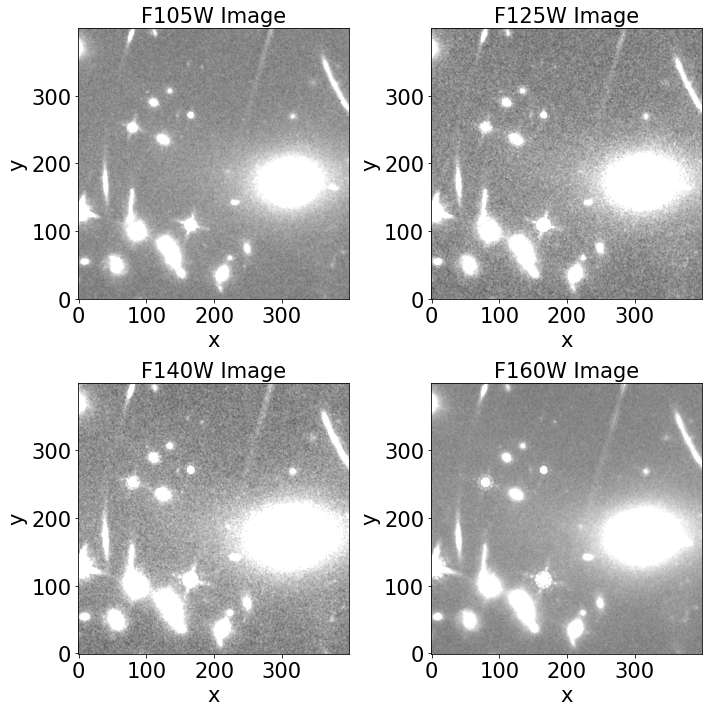

In [52]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes,cutimglist, ['F105W', 'F125W', 'F140W', 'F160W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

## Classify Images <a name="classification"></a>

To classify an image, use [Classifer.classify](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.classify).
The arguments can be either a file path or a numpy array. The output is a dictionary that contains the
classifications as numpy arrays.

The output is a dictionary that contains a mapping for each pixel which represents the 
probability that a pixel belongs to one of the following classes:

- Spheroid
- Disk
- Irregular
- Point Source (Compact)
- Background

It also contains a mapping for `n`, which indicates how many times a classification was
recorded for that pixel

In [22]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)

classifying:   0%|          | 0/130 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate)


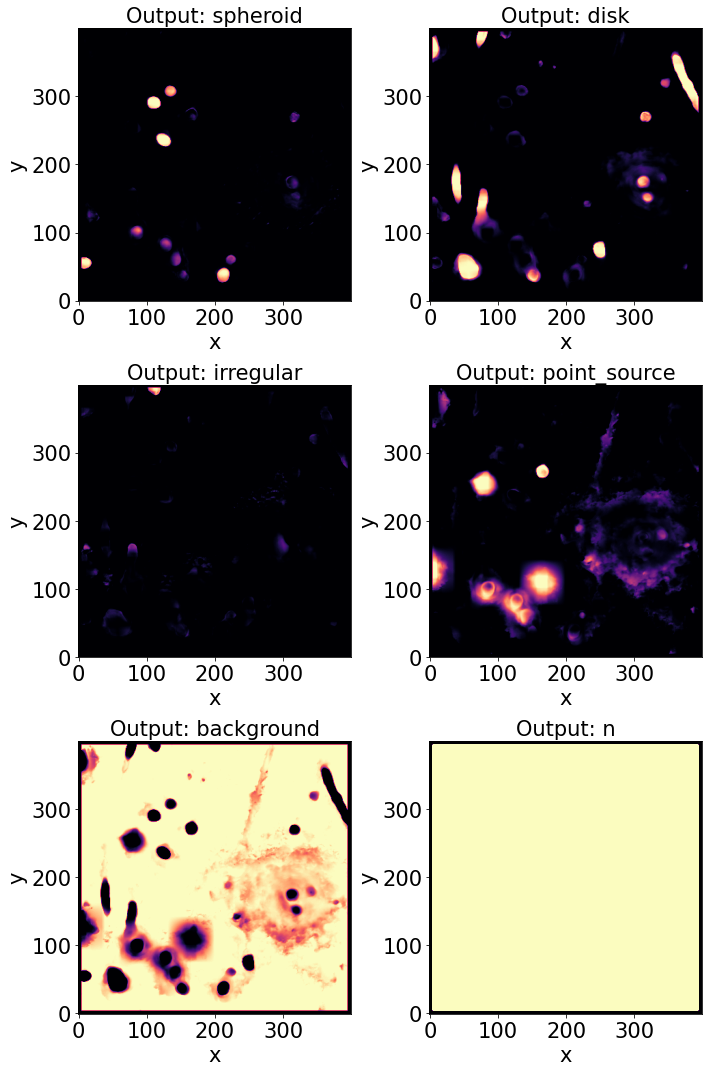

In [21]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = np.array(axes).flatten()

for i, k in enumerate(classified):
    axes[i].set_title(f'Output: {k}', fontsize = 21)
    axes[i].imshow(classified[k], origin='lower', vmin=0, vmax=1, cmap='magma')
    axes[i].set_xlabel('x', fontsize=21)
    axes[i].set_ylabel('y', fontsize=21)
    axes[i].tick_params(axis='x', labelsize=21)
    axes[i].tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

## Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [37]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)

/tmp/ipykernel_39029/1095004680.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 100%|██████████| 23/23 [00:00<00:00, 1429.47it/s]


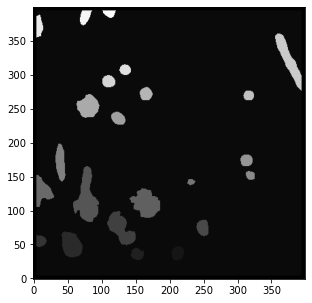

In [38]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='gray')
plt.show()

## Cataloging <a name="cataloging"></a>

Morpheus provides a cataloging functionality via [Classifier.catalog_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.catalog_from_classified)
for images that will return all of the detected sources and their morphological classifications.


In [39]:
catalog = Classifier.catalog_from_classified(classified, hcut, segmap)

In [40]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[37, 213]	[0.91 0.01 0.   0.08]
2		[38, 152]	[0.13 0.74 0.05 0.08]
3		[47, 56]	[0.   0.97 0.03 0.  ]
4		[55, 9]	[0.95 0.05 0.   0.  ]
5		[80, 129]	[0.26 0.01 0.   0.73]
6		[75, 249]	[0.   0.99 0.01 0.  ]
7		[99, 86]	[0.32 0.15 0.01 0.52]
8		[109, 166]	[0. 0. 0. 1.]
9		[128, 5]	[0.02 0.03 0.01 0.94]
10		[141, 231]	[0.02 0.24 0.05 0.69]
11		[166, 41]	[0.   0.98 0.02 0.  ]
12		[152, 320]	[0.15 0.77 0.   0.08]
13		[172, 313]	[0.15 0.8  0.   0.06]
14		[235, 125]	[0.99 0.   0.   0.  ]
15		[253, 80]	[0. 0. 0. 1.]
16		[271, 166]	[0.1 0.  0.  0.9]
17		[269, 317]	[0.21 0.77 0.01 0.  ]
18		[289, 392]	[0.   0.97 0.02 0.  ]
19		[289, 111]	[0.99 0.01 0.   0.  ]
20		[307, 135]	[0.82 0.1  0.02 0.05]
21		[369, 5]	[0.   0.97 0.02 0.01]
22		[392, 79]	[0.   0.97 0.03 0.  ]
23		[394, 113]	[0.  0.1 0.9 0. ]


## Colorizing A Morphological Classification <a name="colorizing_a_morphological_classification"></a>

Use [Classifier.colorize_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified)  to make an RGB. The colors in the output have the following meanings:

- Red = Spheroid
- Blue = Disk
- Green = Irregular
- Yellow = Point Source (compact)
- Back = Background

Note when Morpheus doesn't output a strong classification for any one class they are colored white.

For more information on the coloring scheme see the [documentation](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified).

100%|██████████| 400/400 [00:00<00:00, 872.43it/s] 


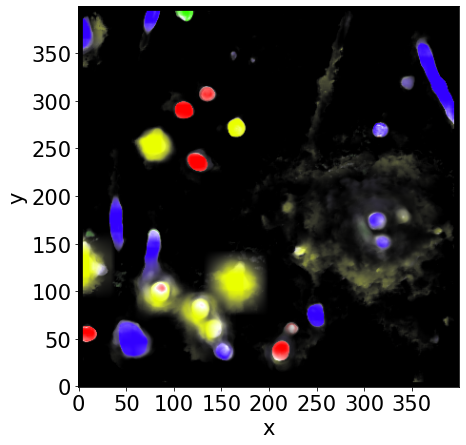

In [26]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(7, 7))
plt.xlabel('x', fontsize=21)
plt.ylabel('y', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.imshow(rgb, origin='lower')
plt.show()

### Morpheus (segmap from SExtractor)

In [42]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS

wcs = WCS(h_header.header)
''' 
morpheus_result = pd.DataFrame(columns=['id', 'loc', 'morph', 'radec'])
# id, loc, morph, radec = [], [], [],[]
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]\tRA/DEC')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    radec = pixel_to_skycoord(loc[0], loc[1], wcs)
    print('{}\t\t{}\t{}\t{}'.format(_id, loc, morph, radec))
    #newrow = pd.DataFrame([_id, loc, morph, radec])
'''

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')


morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')



for i in range(np.size(morpheus_result['ra'])):
    #morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).ra.degree
    #morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['location'][i][0], morpheus_result['location'][i][1], wcs).dec.degree
    morpheus_result['x'][i] = morpheus_result['location'][i][0]
    morpheus_result['y'][i] = morpheus_result['location'][i][1]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+2300
morpheus_result['real_y'] = morpheus_result['y']+2300

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree

# morpheus_result['radec'] = pixel_to_skycoord(morpheus_result['location'][0], morpheus_result['location'][1], wcs)


/tmp/ipykernel_39029/370731371.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_39029/370731371.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_39029/370731371.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
/

In [43]:
morpheus_result

,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[37, 213]","[0.9064245895039771, 0.009600201210295624, 0.0...",110.842971,-73.453969,37.0,213.0,0.906425,0.009600,0.000318,0.083657,2337.0,2513.0
1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.842913,-73.454986,38.0,152.0,0.133510,0.739447,0.051676,0.075367,2338.0,2452.0
2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.842387,-73.456586,47.0,56.0,0.000004,0.971159,0.028812,0.000025,2347.0,2356.0
3,4,"[55, 9]","[0.9510512335886596, 0.04620197523001421, 0.00...",110.841919,-73.457369,55.0,9.0,0.951051,0.046202,0.002734,0.000012,2355.0,2309.0
4,5,"[80, 129]","[0.25933342939630366, 0.011352716694004752, 0....",110.840455,-73.455369,80.0,129.0,0.259333,0.011353,0.002790,0.726524,2380.0,2429.0
5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.840747,-73.453369,75.0,249.0,0.003139,0.985521,0.009156,0.002184,2375.0,2549.0
6,7,"[99, 86]","[0.32355014448582087, 0.1462087157289299, 0.00...",110.839343,-73.456086,99.0,86.0,0.323550,0.146209,0.009874,0.520367,2399.0,2386.0
7,8,"[109, 166]","[0.0009006338355220271, 0.0011091731694645303,...",110.838758,-73.454753,109.0,166.0,0.000901,0.001109,0.001328,0.996662,2409.0,2466.0
8,9,"[128, 5]","[0.015289449822939432, 0.031671113099609745, 0...",110.837646,-73.457436,128.0,5.0,0.015289,0.031671,0.011409,0.941631,2428.0,2305.0
9,10,"[141, 231]","[0.020714850848764985, 0.2442561242045609, 0.0...",110.836885,-73.453669,141.0,231.0,0.020715,0.244256,0.045155,0.689874,2441.0,2531.0


In [44]:
morpheus_result.to_csv("morpheus_result.csv")
morpheus_result


,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[37, 213]","[0.9064245895039771, 0.009600201210295624, 0.0...",110.842971,-73.453969,37.0,213.0,0.906425,0.009600,0.000318,0.083657,2337.0,2513.0
1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.842913,-73.454986,38.0,152.0,0.133510,0.739447,0.051676,0.075367,2338.0,2452.0
2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.842387,-73.456586,47.0,56.0,0.000004,0.971159,0.028812,0.000025,2347.0,2356.0
3,4,"[55, 9]","[0.9510512335886596, 0.04620197523001421, 0.00...",110.841919,-73.457369,55.0,9.0,0.951051,0.046202,0.002734,0.000012,2355.0,2309.0
4,5,"[80, 129]","[0.25933342939630366, 0.011352716694004752, 0....",110.840455,-73.455369,80.0,129.0,0.259333,0.011353,0.002790,0.726524,2380.0,2429.0
5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.840747,-73.453369,75.0,249.0,0.003139,0.985521,0.009156,0.002184,2375.0,2549.0
6,7,"[99, 86]","[0.32355014448582087, 0.1462087157289299, 0.00...",110.839343,-73.456086,99.0,86.0,0.323550,0.146209,0.009874,0.520367,2399.0,2386.0
7,8,"[109, 166]","[0.0009006338355220271, 0.0011091731694645303,...",110.838758,-73.454753,109.0,166.0,0.000901,0.001109,0.001328,0.996662,2409.0,2466.0
8,9,"[128, 5]","[0.015289449822939432, 0.031671113099609745, 0...",110.837646,-73.457436,128.0,5.0,0.015289,0.031671,0.011409,0.941631,2428.0,2305.0
9,10,"[141, 231]","[0.020714850848764985, 0.2442561242045609, 0.0...",110.836885,-73.453669,141.0,231.0,0.020715,0.244256,0.045155,0.689874,2441.0,2531.0


### Catalog _ Relics

In [12]:
colnames_cat = ['id', 'RA','Dec', 'x', 'y', 'fwhm', 
'area', 'stel', 'ell', 'theta', 'nf5sig', 'nfobs', 'f435w_mag', 'f435w_magerr',
'f435w_flux', 'f435w_fluxerr', 'f435w_fluxnJy', 'f435w_fluxnJyerr', 'f435w_sig', 'f606w_mag', 'f606w_magerr', 'f606w_flux', 
'f606w_fluxerr' , 'f606w_fluxnJy', 'f606w_fluxnJyerr', 'f606w_sig', 'f814w_mag', 'f814w_magerr', 'f814w_flux', 'f814w_fluxerr', 
'f814w_fluxnJy', 'f814w_fluxnJyerr' , 'f814w_sig' , 'f105w_mag', 'f105w_magerr', 'f105w_flux', 'f105w_fluxerr', 'f105w_fluxnJy', 
'f105w_fluxnJyerr', 'f105w_sig', 'f125w_mag', 'f125w_magerr', 'f125w_flux', 'f125w_fluxerr', 'f125w_fluxnJy', 'f125w_fluxnJyerr', 'f125w_sig', 
'f140w_mag', 'f140w_magerr', 'f140w_flux', 'f140w_fluxerr', 'f140w_fluxnJy', 'f140w_fluxnJyerr', 'f140w_sig', 'f160w_mag', 'f160w_magerr', 'f160w_flux',
'f160w_fluxerr', 'f160w_fluxnJy', 'f160w_fluxnJyerr', 'f160w_sig', 'bright_mag', 'bright_magerr', 'zb', 'zbmin', 'zbmax', 'tb', 'odds', 'chisq', 
'chisq2', 'M0', 'zml', 'tml'] 
dat_cat = np.genfromtxt('../../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_cat = pd.DataFrame(dat_cat)

In [13]:
dat_cat

,id,RA,Dec,x,y,fwhm,area,stel,ell,theta,...,zb,zbmin,zbmax,tb,odds,chisq,chisq2,M0,zml,tml
0,1,110.849871,-73.476351,2220.471,1171.080,0.293,358,0.20,0.179,-8.1,...,1.358,1.276,1.440,6.3,0.975,4.098,0.319,23.384,1.36,6.3
1,2,110.815039,-73.428125,2815.757,4064.595,0.418,52,0.04,0.361,-23.3,...,0.669,0.628,0.770,10.6,0.825,18.564,19.274,25.529,0.67,10.9
2,3,110.819121,-73.428625,2745.900,4034.629,0.445,17,0.70,0.135,-27.4,...,0.612,0.157,1.902,10.1,0.226,1.009,1.456,26.782,0.60,10.2
3,4,110.814922,-73.429087,2817.735,4006.911,0.550,38,0.44,0.186,-14.0,...,1.379,0.741,1.900,7.1,0.308,1.436,1.286,27.616,1.58,7.1
4,5,110.823069,-73.429066,2678.331,4008.189,0.545,16,0.30,0.305,-17.2,...,0.911,0.444,5.503,8.2,0.259,1.009,1.272,26.890,5.47,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,1471,110.846271,-73.476261,2281.897,1176.475,0.611,108,0.02,0.419,1.9,...,1.412,1.175,1.763,8.7,0.435,0.599,0.412,24.989,1.41,8.7
1471,1472,110.846431,-73.477537,2279.194,1099.891,0.284,2145,0.99,0.002,-72.3,...,0.613,0.462,1.414,9.4,0.625,0.004,0.058,16.892,1.84,7.0
1472,1473,110.849344,-73.476835,2229.464,1142.005,0.245,1489,0.96,0.119,-23.9,...,0.338,0.305,0.393,10.0,0.973,0.000,0.993,18.660,3.27,10.6
1473,1474,110.846212,-73.476491,2282.908,1162.646,0.441,40,0.16,0.203,-2.9,...,0.923,0.598,1.117,9.5,0.521,0.791,0.802,25.691,0.93,9.5


In [14]:
dat_cat = dat_cat.loc[dat_cat['x'] > 2500-200]
dat_cat = dat_cat.loc[dat_cat['x'] < 2500+200]
dat_cat = dat_cat.loc[dat_cat['y'] > 2500-200]
dat_cat = dat_cat.loc[dat_cat['y'] < 2500+200]
dat_cat
dat_cat.to_csv("catalog_source.csv")

### SExtractor _ Stellarity

In [15]:
colnames = ['x','y','num','mag_auto','merr_auto','mag_iso','merr_iso','mag_iso', 'magerr_iso','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']
band = ["F105W", "F160W"]
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/Threshold=Low(Segmap-generation_Morpheus)/{}.cat'.format(band[0]), dtype=None, encoding='ascii', names=colnames)
dat_0 = pd.DataFrame(dat_0)

In [16]:
dat_0 = dat_0.loc[dat_0['x'] > 2500-200]
dat_0 = dat_0.loc[dat_0['x'] < 2500+200]
dat_0 = dat_0.loc[dat_0['y'] > 2500-200]
dat_0 = dat_0.loc[dat_0['y'] < 2500+200]
dat_0

,x,y,num,mag_auto,merr_auto,mag_iso,merr_iso,mag_iso_1,magerr_iso,kron,...,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
695,2614.1765,2473.8076,696,18.3138,0.0015,18.4598,0.0016,18.4371,0.0016,3.50,...,110.826808,-73.454639,21.422,20.411,37.61,18.5436,3,8.02,22.711,0.029
856,2387.3083,2400.0132,857,19.9124,0.0025,19.8950,0.0027,19.8799,0.0027,3.50,...,110.840086,-73.455869,7.037,6.742,-37.96,18.0864,3,5.16,4.733,0.034
861,2357.3503,2350.1982,862,21.2653,0.0092,21.3176,0.0080,21.2545,0.0078,3.50,...,110.841840,-73.456699,8.925,7.963,-66.15,21.3200,3,18.14,10.388,0.026
862,2513.6921,2337.4600,863,20.4277,0.0031,20.3960,0.0034,20.3814,0.0034,3.50,...,110.832689,-73.456912,5.536,4.661,55.32,18.3169,3,4.93,3.864,0.178
876,2442.8674,2361.2419,877,20.8577,0.0046,20.8785,0.0046,20.8591,0.0046,3.50,...,110.836834,-73.456515,7.514,5.119,51.74,19.2268,3,5.34,6.040,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,2412.7415,2694.8398,1357,23.7498,0.0397,23.8618,0.0308,23.7447,0.0295,3.50,...,110.838596,-73.450955,4.169,3.423,-65.34,22.3640,2,11.54,5.142,0.012
1357,2491.0391,2652.7546,1358,27.5206,0.4904,28.1819,0.3329,27.5885,0.2708,5.45,...,110.834015,-73.451657,1.228,0.764,-28.41,24.3332,0,0.00,2.053,0.432
1361,2371.4871,2665.3503,1362,26.3169,0.2855,27.0565,0.1885,26.6542,0.1637,6.55,...,110.841010,-73.451447,2.027,1.086,-53.03,24.2412,3,8.88,3.297,0.080
1366,2322.2615,2664.4814,1367,26.6021,0.2301,27.0394,0.1659,26.7733,0.1511,5.94,...,110.843891,-73.451461,1.667,1.140,-63.24,23.8742,3,8.24,2.207,0.021


In [17]:
dat_0.to_csv("SExtractor_result.csv")

In [18]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
1,1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.842913,-73.454986,38.0,152.0,0.133510,0.739447,0.051676,0.075367,2338.0,2452.0
2,2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.842387,-73.456586,47.0,56.0,0.000004,0.971159,0.028812,0.000025,2347.0,2356.0
5,5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.840747,-73.453369,75.0,249.0,0.003139,0.985521,0.009156,0.002184,2375.0,2549.0
10,10,11,"[166, 41]","[2.831416647493969e-06, 0.9808198775880248, 0....",110.835422,-73.456836,166.0,41.0,0.000003,0.980820,0.018279,0.000898,2466.0,2341.0
11,11,12,"[152, 320]","[0.14826546583591302, 0.7726052666493453, 0.00...",110.836241,-73.452186,152.0,320.0,0.148265,0.772605,0.000918,0.078212,2452.0,2620.0
12,12,13,"[172, 313]","[0.14518250549341702, 0.796515884954872, 4.937...",110.835070,-73.452303,172.0,313.0,0.145183,0.796516,0.000005,0.058297,2472.0,2613.0
16,16,17,"[269, 317]","[0.21465392847822623, 0.770822205641764, 0.013...",110.829394,-73.452236,269.0,317.0,0.214654,0.770822,0.013815,0.000708,2569.0,2617.0
17,17,18,"[289, 392]","[0.00010299864016631229, 0.974810267896747, 0....",110.828224,-73.450986,289.0,392.0,0.000103,0.974810,0.024478,0.000609,2589.0,2692.0
20,20,21,"[369, 5]","[0.0005651646029873465, 0.9704477687665133, 0....",110.823539,-73.457436,369.0,5.0,0.000565,0.970448,0.023257,0.005730,2669.0,2305.0
21,21,22,"[392, 79]","[8.018094066012201e-05, 0.9662492872442597, 0....",110.822194,-73.456202,392.0,79.0,0.000080,0.966249,0.032958,0.000713,2692.0,2379.0


In [23]:
rgb = Classifier.colorize_classified(classified)


100%|██████████| 400/400 [00:00<00:00, 1068.11it/s]


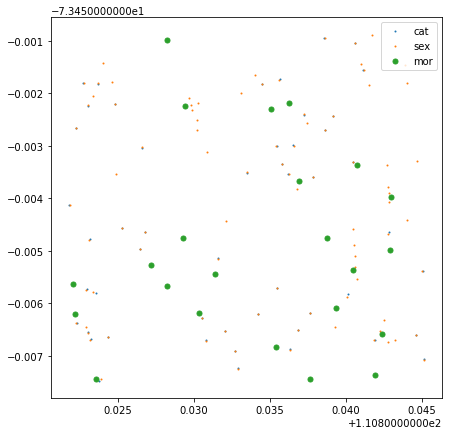

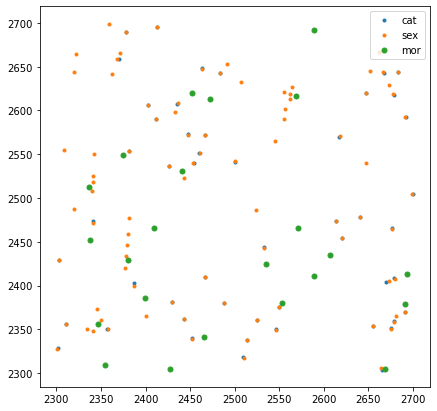

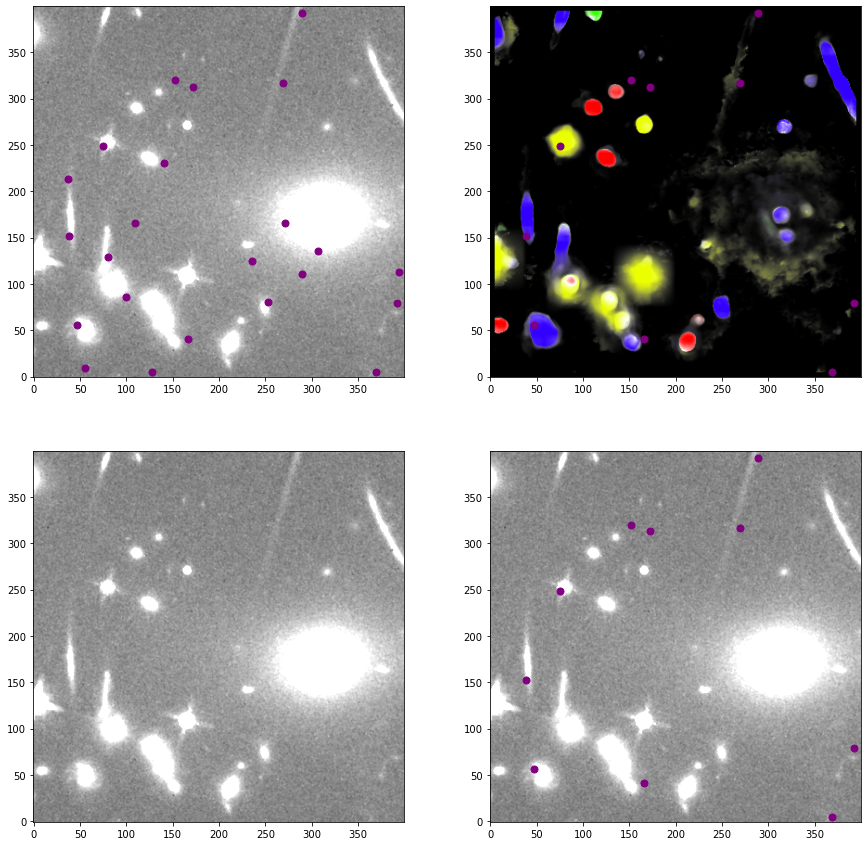

In [65]:
datcat = pd.DataFrame(pd.read_csv("catalog_source.csv"))
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datsex = pd.DataFrame(pd.read_csv("SExtractor_result.csv"))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(datcat['RA'], datcat['Dec'],'o',ms=1,label='cat')
ax.plot(datsex['ra'], datsex['dec'],'o',ms=1,label='sex')
ax.plot(datmor['ra'], datmor['dec'],'o',ms=5,label='mor')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(7,7))
# ax.imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
ax.plot(datcat['x'], datcat['y'],'o',ms=3,label='cat')
ax.plot(datsex['x'], datsex['y'],'o',ms=3,label='sex')
ax.plot(datmor['real_x'], datmor['real_y'],'o',ms=5,label='mor')
ax.legend()



fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs[0,0].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
axs[0,0].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple')

axs[0,1].imshow(rgb, origin='lower')
axs[0,1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'o', ms=7, color='purple')


axs[1,0].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)




axs[1,1].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
axs[1,1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'o', ms=7, color='purple')

